## Calculate temperature profiles under different modelling assumptions

In [1]:
# Set directory
ROOT_DIR = abspath(joinpath(pwd(),"../../"))
if !haskey(ENV, "RAD_DIR")
    ENV["RAD_DIR"] = joinpath(ROOT_DIR,"socrates")
end

In [2]:
# Import system packages
using Pkg
using Revise

using Printf
using DelimitedFiles
using Plots
default(label=nothing, grid=true)

In [95]:
using LaTeXStrings

In [4]:
# Import AGNI
Pkg.activate(ROOT_DIR)
using AGNI

# Normal logging from AGNI module
AGNI.setup_logging("",2)

  Activating project at `~/AGNI`


In [5]:
R_earth = 6.371e6 # m
S_earth = 1361.0 # W/m^2

1361.0

### Define atmosphere parameters

In [6]:
# Configuration options
instellation    = 2 * S_earth  # Solar flux [W m-2]
gravity         = 9.81
radius          = 1 * R_earth
zenith          = 54.74
albedo          = 0.0
s0_fact         = 0.25
nlev_centre     = 45
p_surf          = 300.0     # bar
t_surf          = 2000.0
p_top           = 1e-5      # bar
mole_fractions  = Dict([ ("H2O", 0.4), ("H2", 0.6)])

spectral_file = joinpath(ROOT_DIR,"res/spectral_files/Dayspring/48/Dayspring.sf")
star_file     = joinpath(ROOT_DIR,"res/stellar_spectra/sun.txt");


In [7]:
# Create output directory
output_dir = joinpath(ROOT_DIR,"out")
rm(output_dir,force=true,recursive=true)
mkdir(output_dir);

### Initialise the atmosphere

In [8]:
# Setup atmosphere
atmos = atmosphere.Atmos_t()
atmosphere.setup!(atmos, ROOT_DIR, output_dir,
                        spectral_file,
                        instellation, s0_fact, albedo, zenith,
                        t_surf,
                        gravity, radius,
                        nlev_centre, p_surf, p_top,
                        mole_fractions, "",
                        flag_gcontinuum=true,
                        flag_rayleigh=true,
                        thermo_functions=true
                        )
atmosphere.allocate!(atmos, star_file)
setpt.isothermal!(atmos, t_surf)

[ INFO  ] Setting-up a new atmosphere struct 
[ DEBUG ] AGNI VERSION = 1.7.9 
[ DEBUG ] Using SOCRATES at /home/n/nichollsh/AGNI/socrates 
[ DEBUG ] SOCRATES VERSION = 2407.2 
[ DEBUG ] Composition set by dict 
[ INFO  ] Loading thermodynamic data 
[ DEBUG ] Loading data for gas H2O 
[ DEBUG ]     ncdf 
[ DEBUG ]     using 'AQUA' equation of state 
[ DEBUG ]     done 
[ DEBUG ] Loading data for gas H2 
[ DEBUG ]     ncdf 
[ DEBUG ]     using 'CMS19' equation of state 
[ DEBUG ]     done 
[ DEBUG ] FastChem env has been set 
[ DEBUG ] Found FastChem executable 
[ DEBUG ] Fastchem working dir defaulting to /home/n/nichollsh/AGNI/out/fastchem/ 
[ DEBUG ] Setup complete 
[ DEBUG ] Allocate atmosphere 
[ DEBUG ] Inserting stellar spectrum into spectral file 
[ DEBUG ] Inserting stellar spectrum from file /home/n/nichollsh/AGNI/res/stellar_spectra/sun.txt 
[ DEBUG ] Read stellar spectrum from file 
[ DEBUG ] Writing stellar spectrum to SOCRATES format 
[ DEBUG ] Using prep_spec at: /home/n/n

In [9]:
atmos_results::Dict{String, atmosphere.Atmos_t} = Dict{String, atmosphere.Atmos_t}()

Dict{String, AGNI.atmosphere.Atmos_t}()

## Run the model under various scenarios

### Fixed surface temperature

In [10]:
atmos.tmp_surf = deepcopy(t_surf)
println(atmos.tmp_surf)

2000.0


In [ ]:
# Isothermal
setpt.isothermal!(atmos, atmos.tmp_surf)
atmosphere.calc_layer_props!(atmos)
energy.calc_fluxes!(atmos; radiative=true, convective=true)
atmosphere.calc_observed_rho!(atmos)
atmos_results["1_iso"] = deepcopy(atmos)
;

In [ ]:
# Adiabatic
setpt.dry_adiabat!(atmos)
atmosphere.calc_layer_props!(atmos)
energy.calc_fluxes!(atmos; radiative=true, convective=true)
atmosphere.calc_observed_rho!(atmos)
atmos_results["1_ad"] = deepcopy(atmos)
;

In [ ]:
# Adiabatic + stratosphere
setpt.dry_adiabat!(atmos)
setpt.stratosphere!(atmos, phys.calc_Tskin(atmos.instellation, atmos.albedo_b))
atmosphere.calc_layer_props!(atmos)
energy.calc_fluxes!(atmos; radiative=true, convective=true)
atmosphere.calc_observed_rho!(atmos)
atmos_results["1_ad+strat"] = deepcopy(atmos)
;

In [14]:
# Radiative-convective
setpt.isothermal!(atmos, t_surf) # initial guess
succ = solver.solve_energy!(atmos,
                                    sol_type=1,
                                    method=1,
                                    dx_max=200.0,
                                    ls_method=2,
                                    modplot=0,
                                    save_frames=false,
                                    detect_plateau=false
                                    )
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)
atmos_results["1_radconv"] = deepcopy(atmos)
;

[ INFO  ]     chem_type = 0 
[ INFO  ]     sol_type  = 1 
[ INFO  ]     tmp_surf  = 2000.00 K 
[ INFO  ]     step  resid_med    cost     flux_OLR    max(x)    max(|dx|)   flags 
[ DEBUG ]         iterate 
[ DEBUG ]         jacobian 
[ DEBUG ]         linesearch 
[ INFO  ]        1  -4.74e+02  2.473e+05  7.291e+05  2.000e+03  1.400e+02  C2-Nr-Ls 
[ DEBUG ]         check convergence 
[ DEBUG ]         iterate 
[ DEBUG ]         jacobian 
[ DEBUG ]         linesearch 
[ INFO  ]        2  -3.41e+02  1.612e+05  4.955e+05  2.000e+03  2.000e+02  C2-Nr 
[ DEBUG ]         check convergence 
[ DEBUG ]         iterate 
[ DEBUG ]         jacobian 
[ DEBUG ]         linesearch 
[ INFO  ]        3  -2.98e+02  1.191e+05  3.590e+05  2.000e+03  2.000e+02  C2-Nr 
[ DEBUG ]         check convergence 
[ DEBUG ]         iterate 
[ DEBUG ]         jacobian 
[ DEBUG ]         linesearch 
[ INFO  ]        4  -2.38e+02  8.802e+04  2.603e+05  2.000e+03  2.000e+02  C2-Nr 
[ DEBUG ]         check convergence 
[ D

### Solving for energy balance

In [15]:
# Isothermal
succ = solver.solve_prescribed!(atmos, sol_type=3, atm_type=1, tmp_upper=1000.0)
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)
atmos_results["3_iso"] = deepcopy(atmos)
;

[ DEBUG ]     try tmp_surf = 383.2020792276049 K 
[ DEBUG ]     flux_tot = 870.2830010959487 
[ DEBUG ]     try tmp_surf = 618.7979207723951 K 
[ DEBUG ]     flux_tot = 7960.68967155333 
[ DEBUG ]     try tmp_surf = 237.5958415447901 K 
[ DEBUG ]     flux_tot = -168.48977193861208 
[ DEBUG ]     try tmp_surf = 147.6062376828148 K 
[ DEBUG ]     flux_tot = -316.9770742043856 
[ DEBUG ]     try tmp_surf = 293.21247536562964 K 
[ DEBUG ]     flux_tot = 68.24616519905828 
[ DEBUG ]     try tmp_surf = 327.58544540676536 K 
[ DEBUG ]     flux_tot = 301.462540317399 
[ DEBUG ]     try tmp_surf = 271.96881158592583 K 
[ DEBUG ]     flux_tot = -40.1863242955169 
[ DEBUG ]     try tmp_surf = 258.83950532449387 K 
[ DEBUG ]     flux_tot = -95.4648392140779 
[ DEBUG ]     try tmp_surf = 280.0831691041977 K 
[ DEBUG ]     flux_tot = -1.6535198078875055 
[ DEBUG ]     try tmp_surf = 285.09811784735786 K 
[ DEBUG ]     flux_tot = 23.911862631488077 
[ DEBUG ]     try tmp_surf = 276.98376032908607 K 


In [16]:
# Adiabatic
succ = solver.solve_prescribed!(atmos, sol_type=3, atm_type=2)
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)
atmos_results["3_ad"] = deepcopy(atmos)
;

[ DEBUG ]     try tmp_surf = 1911.0661242280253 K 
[ DEBUG ]     flux_tot = -346.36063731305615 
[ DEBUG ]     try tmp_surf = 3090.9338757719747 K 
[ DEBUG ]     flux_tot = -285.14524331491475 
[ DEBUG ]     try tmp_surf = 3820.132248456051 K 
[ DEBUG ]     flux_tot = 282.4242443435594 
[ DEBUG ]     try tmp_surf = 4270.801627315924 K 
[ DEBUG ]     flux_tot = 973.7142089904548 
[ DEBUG ]     try tmp_surf = 3541.603254631847 K 
[ DEBUG ]     flux_tot = -5.159335532366413 
[ DEBUG ]     try tmp_surf = 3369.462869596179 K 
[ DEBUG ]     flux_tot = -124.53377974424018 
[ DEBUG ]     try tmp_surf = 3647.991863420383 K 
[ DEBUG ]     flux_tot = 80.286797073233 
[ DEBUG ]     try tmp_surf = 3475.851478384716 K 
[ DEBUG ]     flux_tot = -72.0648381757527 
[ DEBUG ]     try tmp_surf = 3582.2400871732516 K 
[ DEBUG ]     flux_tot = 43.54871849831932 
[ DEBUG ]     try tmp_surf = 3516.4883109261204 K 
[ DEBUG ]     flux_tot = -31.988869662688046 
[ DEBUG ]     try tmp_surf = 3557.1251434675255 K

In [17]:
# Adiabatic + stratosphere
succ = solver.solve_prescribed!(atmos, sol_type=3, atm_type=3)
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)
atmos_results["3_ad+strat"] = deepcopy(atmos)
;

[ DEBUG ]     try tmp_surf = 1911.0661242280253 K 
[ DEBUG ]     flux_tot = -12.176605807677731 
[ DEBUG ]     try tmp_surf = 3090.9338757719747 K 
[ DEBUG ]     flux_tot = 140.86170386216907 
[ DEBUG ]     try tmp_surf = 1181.8677515439488 K 
[ DEBUG ]     flux_tot = -10.825575634778204 
[ DEBUG ]     try tmp_surf = 731.1983726840765 K 
[ DEBUG ]     flux_tot = -10.426066727634748 
[ DEBUG ]     try tmp_surf = 452.6693788598721 K 
[ DEBUG ]     flux_tot = -10.30887724252699 
[ DEBUG ]     try tmp_surf = 280.5289938242043 K 
[ DEBUG ]     flux_tot = -10.310036195482041 
[ DEBUG ]     try tmp_surf = 559.0579876484087 K 
[ DEBUG ]     flux_tot = -10.314520429562208 
[ DEBUG ]     try tmp_surf = 386.9176026127408 K 
[ DEBUG ]     flux_tot = -10.309535706000702 
[ DEBUG ]     try tmp_surf = 493.3062114012773 K 
[ DEBUG ]     flux_tot = -10.308521786536971 
[ DEBUG ]     try tmp_surf = 518.4211551070035 K 
[ DEBUG ]     flux_tot = -10.30895706463724 
[ DEBUG ]     try tmp_surf = 477.7843225

In [18]:
# Radiative-convective
setpt.isothermal!(atmos, t_surf) # initial guess
succ = solver.solve_energy!(atmos,
                                    sol_type=3,
                                    method=1,
                                    dx_max=200.0,
                                    ls_method=2,
                                    modplot=0,
                                    save_frames=false,
                                    detect_plateau=false
                                    )
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)
atmos_results["3_radconv"] = deepcopy(atmos)
;

[ INFO  ]     chem_type = 0 
[ INFO  ]     sol_type  = 3 
[ INFO  ]     flux_int  = 0.00 W m-2 
[ INFO  ]     step  resid_med    cost     flux_OLR    max(x)    max(|dx|)   flags 
[ DEBUG ]         iterate 
[ DEBUG ]         jacobian 
[ DEBUG ]         linesearch 
[ INFO  ]        1  -4.11e+02  7.390e+05  7.300e+05  1.930e+03  1.400e+02  C2-Nr-Ls 
[ DEBUG ]         check convergence 
[ DEBUG ]         iterate 
[ DEBUG ]         jacobian 
[ DEBUG ]         linesearch 
[ INFO  ]        2  -2.65e+02  5.027e+05  4.973e+05  1.812e+03  2.000e+02  C2-Nr 
[ DEBUG ]         check convergence 
[ DEBUG ]         iterate 
[ DEBUG ]         jacobian 
[ DEBUG ]         linesearch 
[ INFO  ]        3  -1.91e+02  3.651e+05  3.610e+05  1.710e+03  2.000e+02  C2-Nr 
[ DEBUG ]         check convergence 
[ DEBUG ]         iterate 
[ DEBUG ]         jacobian 
[ DEBUG ]         linesearch 
[ INFO  ]        4  -2.02e+02  2.656e+05  2.626e+05  1.634e+03  2.000e+02  C2-Nr 
[ DEBUG ]         check convergence 
[ 

In [19]:
# save to netcdf
for (k,atm) in atmos_results
    save.write_ncdf(atm, joinpath(output_dir,k*".nc"))
end


[ DEBUG ] Writing NetCDF to /home/n/nichollsh/AGNI/out/3_radconv.nc 
[ DEBUG ] Writing NetCDF to /home/n/nichollsh/AGNI/out/1_ad+strat.nc 
[ DEBUG ] Writing NetCDF to /home/n/nichollsh/AGNI/out/3_ad+strat.nc 
[ DEBUG ] Writing NetCDF to /home/n/nichollsh/AGNI/out/1_radconv.nc 
[ DEBUG ] Writing NetCDF to /home/n/nichollsh/AGNI/out/3_iso.nc 
[ DEBUG ] Writing NetCDF to /home/n/nichollsh/AGNI/out/1_iso.nc 
[ DEBUG ] Writing NetCDF to /home/n/nichollsh/AGNI/out/1_ad.nc 
[ DEBUG ] Writing NetCDF to /home/n/nichollsh/AGNI/out/3_ad.nc 


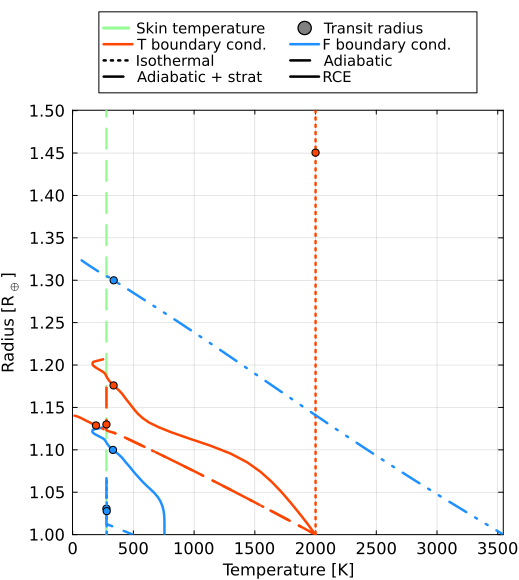

In [209]:
fig1 = plot(legend=:outertop, size=(520,580),
            ylabel=L"Radius [R$_\oplus$]", legendcolumns=2,
            right_margin = 2Plots.mm, bottom_margin=  -3Plots.mm,
            xlabel="Temperature [K]", legendfontsize=10, labelfontsize=11, tickfontsize=11, frame=:box)

lw = 2.5

Teqm = phys.calc_Tskin(atmos.instellation, atmos.albedo_b)
vline!(fig1, [Teqm], ls=:dash, color=:palegreen, lw=lw, label=@sprintf("Skin temperature"))

# default axis limits
y_min = 10.0
y_max = 0.5
x_min = -1
x_max = 10.0


lstyles = Dict([("iso",:dot), ("ad",:dashdotdot), ("ad+strat",:dash), ("radconv",:solid)])

# plot
for (k,atm) in atmos_results

    spl = split(k,"_")

    # line label and color
    if spl[1] == "1"
        col = "orangered"
    else
        col = "dodgerblue"
    end
    ls = lstyles[spl[2]]

    # plot profile
    plot!(fig1, atm.tmp, atm.r / R_earth, lw=lw, linestyle=ls, color=col)

    # plot photosphere point
    atmosphere.calc_observed_rho!(atm)
    rtrans = atm.transspec_r/R_earth
    # plot!(fig, [x_min, atm.transspec_tmp], [rtrans,rtrans], color=col, linealpha=0.5, linestyle=ls)
    scatter!(fig1, [atm.transspec_tmp], [rtrans], color=col)
    # scatter!(fig, [x_min], [rtrans], color=col)

    # axis limits
    y_min = min( minimum(atm.r) / R_earth, y_min)
    y_max = max( rtrans, y_max)
    x_max = max( maximum(atm.tmp), x_max)
end

# legend entries
llw = 2
scatter!(fig1, [], [], label="Transit radius", color=:grey, markersize=6)
plot!(fig1, [], [], lw=llw, label="T boundary cond.    ", lc="orangered", ls=:solid,  )
plot!(fig1, [], [], lw=llw, label="F boundary cond.", lc="dodgerblue",   ls=:solid,  )
plot!(fig1, [], [], lw=llw, label="Isothermal",           lc="black",  ls=:dot,    )
plot!(fig1, [], [], lw=llw, label="Adiabatic",            lc="black",  ls=:dash,   )
plot!(fig1, [], [], lw=llw, label="Adiabatic + strat",    lc="black",  ls=:dashdot,)
plot!(fig1, [], [], lw=llw, label="RCE", lc="black",  ls=:solid,)

y_max += 0.05
yaxis!(ylim=(1.0, y_max), yticks=range(1.0, y_max, step=0.05))
xaxis!(xlim=(x_min, x_max), xticks=range(0.0, x_max, step=500))

display(fig1)

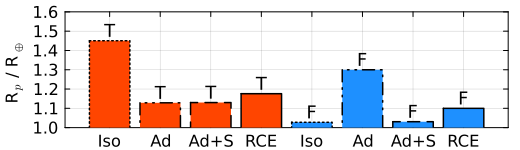

In [210]:
fig2 = plot(legend=:right, size=(520,150),
            ylabel=L"R$_p$ / R$_\oplus$",
            left_margin = 4Plots.mm,
            labelfontsize=11, tickfontsize=11, frame=:box)

# plot
y = Float64[]
x = Float64[]
c = String[]
s = Symbol[]
l = String[]
i = 0
for spl1 in ["1","3"]
    for spl2 in ["iso","ad","ad+strat","radconv"]
        i += 1

        # line label and color
        if spl1 == "1"
            col = "orangered"
            ann = "T"
        elseif spl1 == "3"
            col = "dodgerblue"
            ann = "F"
        end

        if spl2 == "iso"
            lbl = "Iso"
        elseif spl2 == "radconv"
            lbl = "RCE"
        elseif spl2 == "ad"
            lbl = "Ad"
        elseif spl2 == "ad+strat"
            lbl = "Ad+S"
        end

        ls = lstyles[spl2]

        k = "$(spl1)_$(spl2)"

        # add photosphere point
        yy = atmos_results[k].transspec_r/R_earth
        push!(y, yy)
        push!(x, i)
        push!(c, col)
        push!(s, ls)
        push!(l, lbl)

        annotate!(fig2, i, yy, (ann,:bottom, 12))
    end
end

bar!(fig2, x, y, linestyle=s, fillcolor=c, linewidth=1.5)

xaxis!(xticks=(x,l))
yaxis!(ylim=(1,y_max+0.1))

display(fig2)

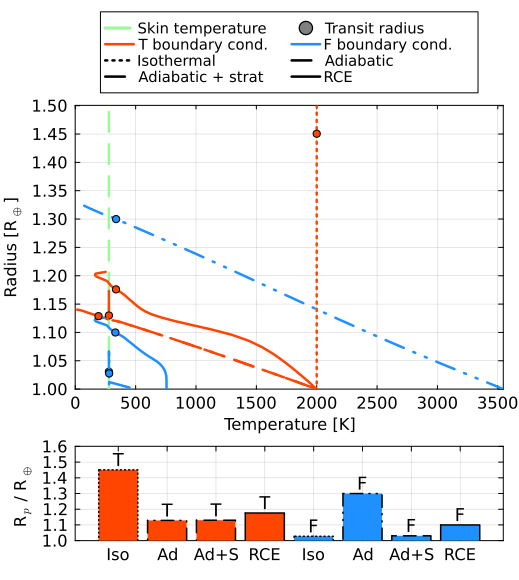

"/home/n/nichollsh/AGNI/out/atmosphere.pdf"

In [211]:
figN = plot(fig1,fig2; layout=grid(2,1, heights=(0.8,0.2)))
display(figN)
savefig(figN, joinpath(output_dir,"atmosphere.pdf"))